# Rectangular data loader

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_003a import *

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'caltech101'

np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, test_pct=0.2)

x = train_ds[-1][0]
classes = train_ds.classes
c = len(classes)

len(train_ds),len(valid_ds),c

(7272, 1872, 102)

## Closest ntile

torch.Size([3, 297, 300])

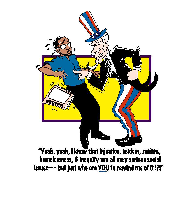

In [4]:
show_image(train_ds[1][0], figsize=(6,3))
x.shape

In [5]:
asp_ratios = [operator.truediv(*Image.open(fn).size) for fn in train_ds.fns]
asp_ratios[:4]

[1.0069444444444444, 0.802937576499388, 1.0, 1.0]

In [6]:
asp_ntiles = np.percentile(asp_ratios, [2,20,50,80,98])
asp_ntiles

array([0.62333333, 0.87666667, 1.3248731 , 1.62361609, 2.8577305 ])

In [7]:
def closest_ntile(aspect, ntiles):
    return ntiles[np.argmin(abs(log(aspect)-log(ntiles)))]

In [8]:
aspect = x.shape[2]/x.shape[1]
nearest_aspect = closest_ntile(aspect, asp_ntiles)
aspect,nearest_aspect

(1.0101010101010102, 0.8766666666666667)

In [9]:
get_crop_target(128, nearest_aspect)

(128, 128)

## SortAspectBatchSampler

In [10]:
asp_nearests = [closest_ntile(o, asp_ntiles) for o in asp_ratios]
asp_nearests[:10]

[0.8766666666666667,
 0.8766666666666667,
 0.8766666666666667,
 0.8766666666666667,
 1.3248730964467006,
 1.623616089207487,
 0.8766666666666667,
 0.8766666666666667,
 1.3248730964467006,
 0.8766666666666667]

In [11]:
bs=32

In [12]:
from itertools import groupby

In [13]:
sort_nearest = sorted(enumerate(asp_nearests), key=itemgetter(1))
groups = [list(b) for a,b in groupby(sort_nearest, key=itemgetter(1))]
len(groups)

5

In [14]:
groups[0][:4]

[(16, 0.6233333333333333),
 (25, 0.6233333333333333),
 (28, 0.6233333333333333),
 (35, 0.6233333333333333)]

In [15]:
sum(math.ceil(len(g)/bs) for g in groups)

229

In [16]:
@dataclass
class SortAspectBatchSampler(Sampler):
    ds:Dataset; bs:int; shuffle:bool = False

    def __post_init__(self):
        asp_ratios = [operator.truediv(*Image.open(img).size) for img in self.ds.fns]
        asp_ntiles = np.percentile(asp_ratios, [2,20,50,80,98])
        asp_nearests = [closest_ntile(o, asp_ntiles) for o in asp_ratios]
        sort_nearest = sorted(enumerate(asp_nearests), key=itemgetter(1))
        self.groups = [list(b) for a,b in groupby(sort_nearest, key=itemgetter(1))]
        self.n = sum(math.ceil(len(g)/bs) for g in self.groups)

    def __len__(self): return self.n
    
    def __iter__(self):
        if self.shuffle: self.groups = sample(self.groups, len(self.groups))
        for group in self.groups:
            group = [(a,{'aspect':b}) for a,b in group]
            if self.shuffle: group = sample(group, len(group))
            for i in range(0, len(group), self.bs): yield group[i:i+self.bs]

In [17]:
next(iter(SortAspectBatchSampler(train_ds, 4)))

[(16, {'aspect': 0.6233333333333333}),
 (25, {'aspect': 0.6233333333333333}),
 (28, {'aspect': 0.6233333333333333}),
 (35, {'aspect': 0.6233333333333333})]

In [18]:
it = iter(SortAspectBatchSampler(train_ds, 4, True))
next(it),next(it)

([(2410, {'aspect': 2.8577304964539003}),
  (1935, {'aspect': 2.8577304964539003}),
  (2304, {'aspect': 2.8577304964539003}),
  (1990, {'aspect': 2.8577304964539003})],
 [(2057, {'aspect': 2.8577304964539003}),
  (2352, {'aspect': 2.8577304964539003}),
  (1983, {'aspect': 2.8577304964539003}),
  (2478, {'aspect': 2.8577304964539003})])

## Rectangular dataset

In [19]:
class TfmDataset(Dataset):
    def __init__(self, ds: Dataset, tfms: Collection[Callable] = None, **kwargs):
        self.ds,self.tfms,self.kwargs = ds,tfms,kwargs
        
    def __len__(self): return len(self.ds)
    def __getattr__(self, k): return getattr(self.ds, k)
#     def fns(self): return self.ds.fns
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,xtra = idx
        else: xtra={}
        x,y = self.ds[idx]
        return apply_tfms(self.tfms)(x, **self.kwargs, **xtra), y

In [20]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,2.))
]

train_tds = TfmDataset(train_ds, tfms)

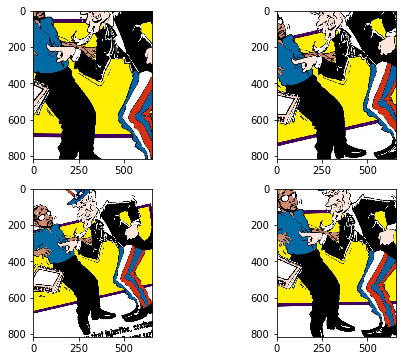

In [21]:
_,axes = plt.subplots(2,2, figsize=(8,6))
for ax in axes.flat: show_image(train_tds[1][0], ax, hide_axis=False)

In [22]:
train_tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,2.), row_pct=(0,1.), col_pct=(0,1.)),
    crop_pad_tfm(row_pct=(0,1.), col_pct=(0,1.))
]
valid_tfms = [
    zoom_tfm(),
    crop_pad_tfm()
]

In [23]:
train_tds = TfmDataset(train_ds, train_tfms)
valid_tds = TfmDataset(valid_ds, valid_tfms)

xtra = {'size':100}
train_tds[(1,xtra)][0].shape

torch.Size([3, 100, 100])

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


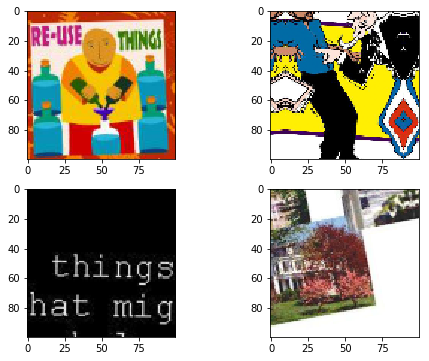

In [24]:
_,axes = plt.subplots(2,2, figsize=(8,6))
for i,ax in enumerate(axes.flat):
    im = train_tds[(i, xtra)][0]
    print(im.shape)
    show_image(im, ax, hide_axis=False)

In [25]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, device=None):
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader(train_dl, device=self.device)
        self.valid_dl = DeviceDataLoader(valid_dl, device=self.device)

    @classmethod
    def create(cls, train_ds, valid_ds, bs=64, device=None, num_workers=4,
               train_tfm=None, valid_tfm=None, sample_func=None):
        if train_tfm is not None: train_tfm = TfmDataset(train_ds, train_tfm)
        if valid_tfm is not None: valid_tfm = TfmDataset(valid_ds, valid_tfm)
        if sample_func is None:
            train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=num_workers)
            valid_dl = DataLoader(valid_ds, bs*2, shuffle=False, num_workers=num_workers)
        else:
            train_samp = sample_func(train_ds, bs, True)
            valid_samp = sample_func(valid_ds, bs*2, False)
            train_dl = DataLoader(train_ds, num_workers=num_workers, batch_sampler=train_samp)
            valid_dl = DataLoader(valid_ds, num_workers=num_workers, batch_sampler=valid_samp)
        return cls(train_dl, valid_dl, device)
        
    @property
    def train_ds(self): return self.train_dl.dl.dataset
    @property
    def valid_ds(self): return self.valid_dl.dl.dataset

In [29]:
train_tds = TfmDataset(train_ds, train_tfms, size=100, padding_mode='zeros')
valid_tds = TfmDataset(valid_ds, valid_tfms, size=100, padding_mode='zeros')

In [30]:
len(train_tds), len(valid_tds)

(7272, 1872)

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


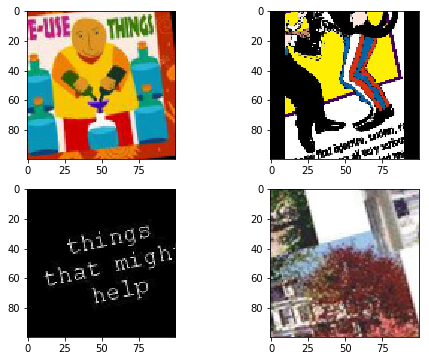

In [32]:
_,axes = plt.subplots(2,2, figsize=(8,6))
for i,ax in enumerate(axes.flat):
    im = train_tds[(i)][0]
    print(im.shape)
    show_image(im, ax, hide_axis=False)

In [33]:
data = DataBunch.create(train_tds, valid_tds, bs, num_workers=0)

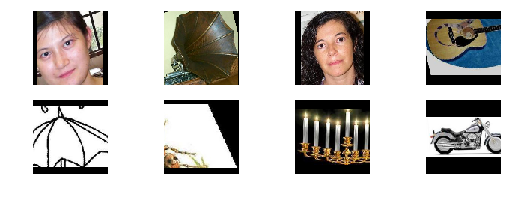

In [34]:
x,y = next(iter(data.train_dl))

_,axes = plt.subplots(2,4, figsize=(9,3))
for i,ax in enumerate(axes.flat): show_image(x[i], ax)

In [53]:
data = DataBunch.create(train_tds, valid_tds, bs, sample_func=SortAspectBatchSampler, num_workers=0)

In [ ]:
print(x[0].shape)
_,axes = plt.subplots(2,4, figsize=(12,4))
for i,ax in enumerate(axes.flat): show_image(x[i], ax, hide_axis=False)

## fin